# Part 1: Understanding Graph Neural Networks

Unlike traditional neural networks, the goal of Graph Neural Network architectures is to produce representations that are then fed to other models, which perform downstream tasks (for example, node classification).
**DeepWalk** is one of the first major successful applications of machine learning (ML) techniques to graph data. It introduces important concepts such as embeddings that are at the core of GNNs.


Proposed in 2014 by Perozzi et al., DeepWalk quickly became extremely popular among graph researchers. Inspired by recent advances in NLP, it consistently outperformed other methods on several datasets. While more performant architectures have been proposed since then, DeepWalk is a simple and reliable baseline that can be quickly implemented to solve a lot of problems.

The goal of DeepWalk is to produce high-quality feature representations of nodes in an unsupervised way. This architecture is heavily inspired by Word2Vec in NLP. However, instead of words, datasets are composed of nodes. This is why DeepWalk use random walks to generate meaningful sequences of nodes that act like sentences.

Random walks are sequences of nodes produced by randomly choosing a neighboring node at every step. Thus, nodes can appear several times in the same sequence.

Why are random walks important? Even if nodes are randomly selected, the fact that they often appear together in a sequence means that they are close to each other. Under the network ***homophily*** hypothesis, nodes that are close to each other are similar. This is particularly the case in social networks, where people are connected to friends and family.

This idea is at the core of the DeepWalk algorithm: when nodes are close to each other, we want to obtain high similarity scores. On the contrary, we want low scores when they are farther apart.

Let's demonstrate this theory:

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(0)


We generate a random graph thanks to the erdos_renyi_graph function with a fixed number of nodes (10) and a predefined probability of creating an edge between two nodes (0.3):

In [ ]:
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


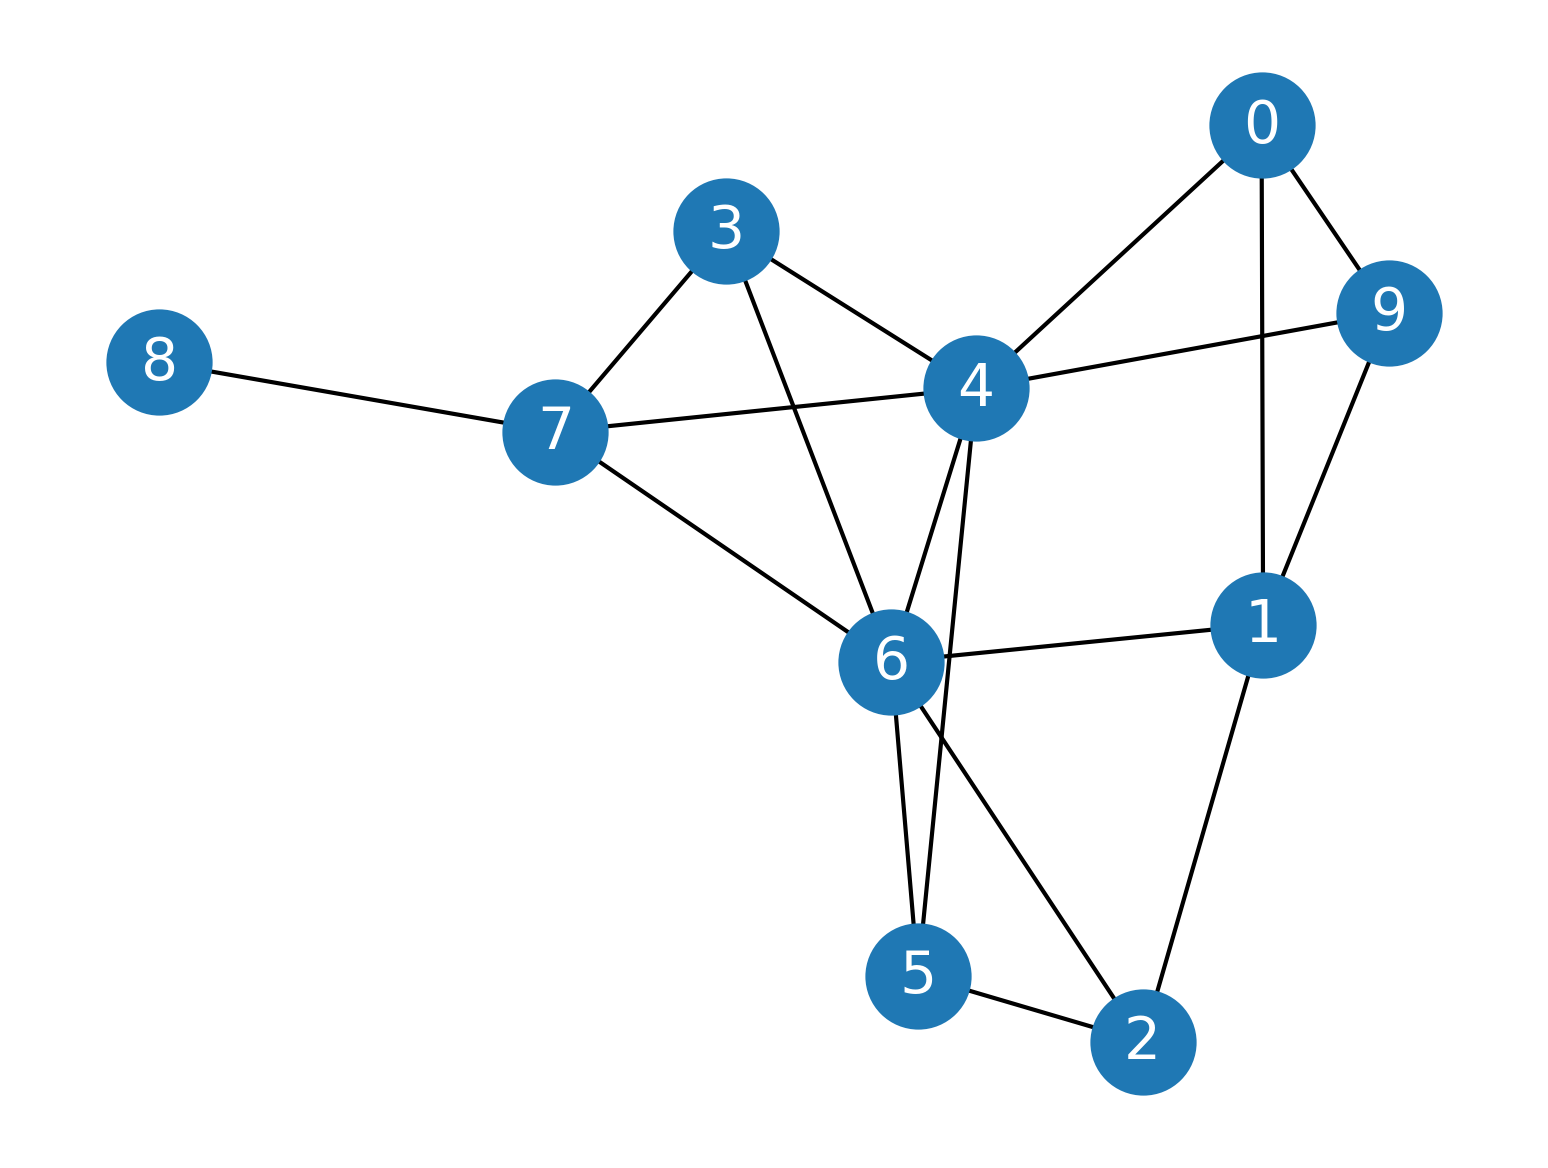

In [ ]:
plt.figure(dpi=300) # lets draw a graph as a figure to make the concepts more familiar
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

Let's now implement a function that will randomly travers the graph. The function needs to start the walk from a provided node and it needs to continue traversing over nodes in the provided lenght.

In [ ]:
def random_walk(start, length):
    walk = [str(start)]  # starting node
    for i in range(length):
        neighbors = [node for node in G.neighbors(start)]
        next_node = np.random.choice(neighbors, 1)[0]
        walk.append(str(next_node))
        start = next_node
    return walk

random_walk(0, 10)

['0', '4', '7', '8', '7', '4', '0', '9', '4', '6', '5']

We can see that certain nodes, such as 0 and 9, are often found together. Considering that it is a homophilic graph, it means that they are similar. It is precisely the type of relationship we’re trying to capture with DeepWalk.

***Let’s now try to use this knowledge and try to solve an ML problem.***

The dataset we will use is Zachary’s Karate Club. It simply represents the relationships within a karate club studied by Wayne W. Zachary in the 1970s. It is a kind of social network where every node is a member, and members who interact outside the club are connected.

In this example, the club is divided into two groups: we would like to assign the right group to every member (node classification) just by looking at their connections

In [ ]:
G = nx.karate_club_graph()  # the graph already exists under networkx imported package

Yet, the graph has string labels (Mr. Hi = 0, Officer = 1). We need to convert these string class labels into numerical values.

In [ ]:
### CELL LABELS ###

labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

Let's plot the graph again. It is always a good practice to do so on small scale, at least when getting familiar with the concepts.

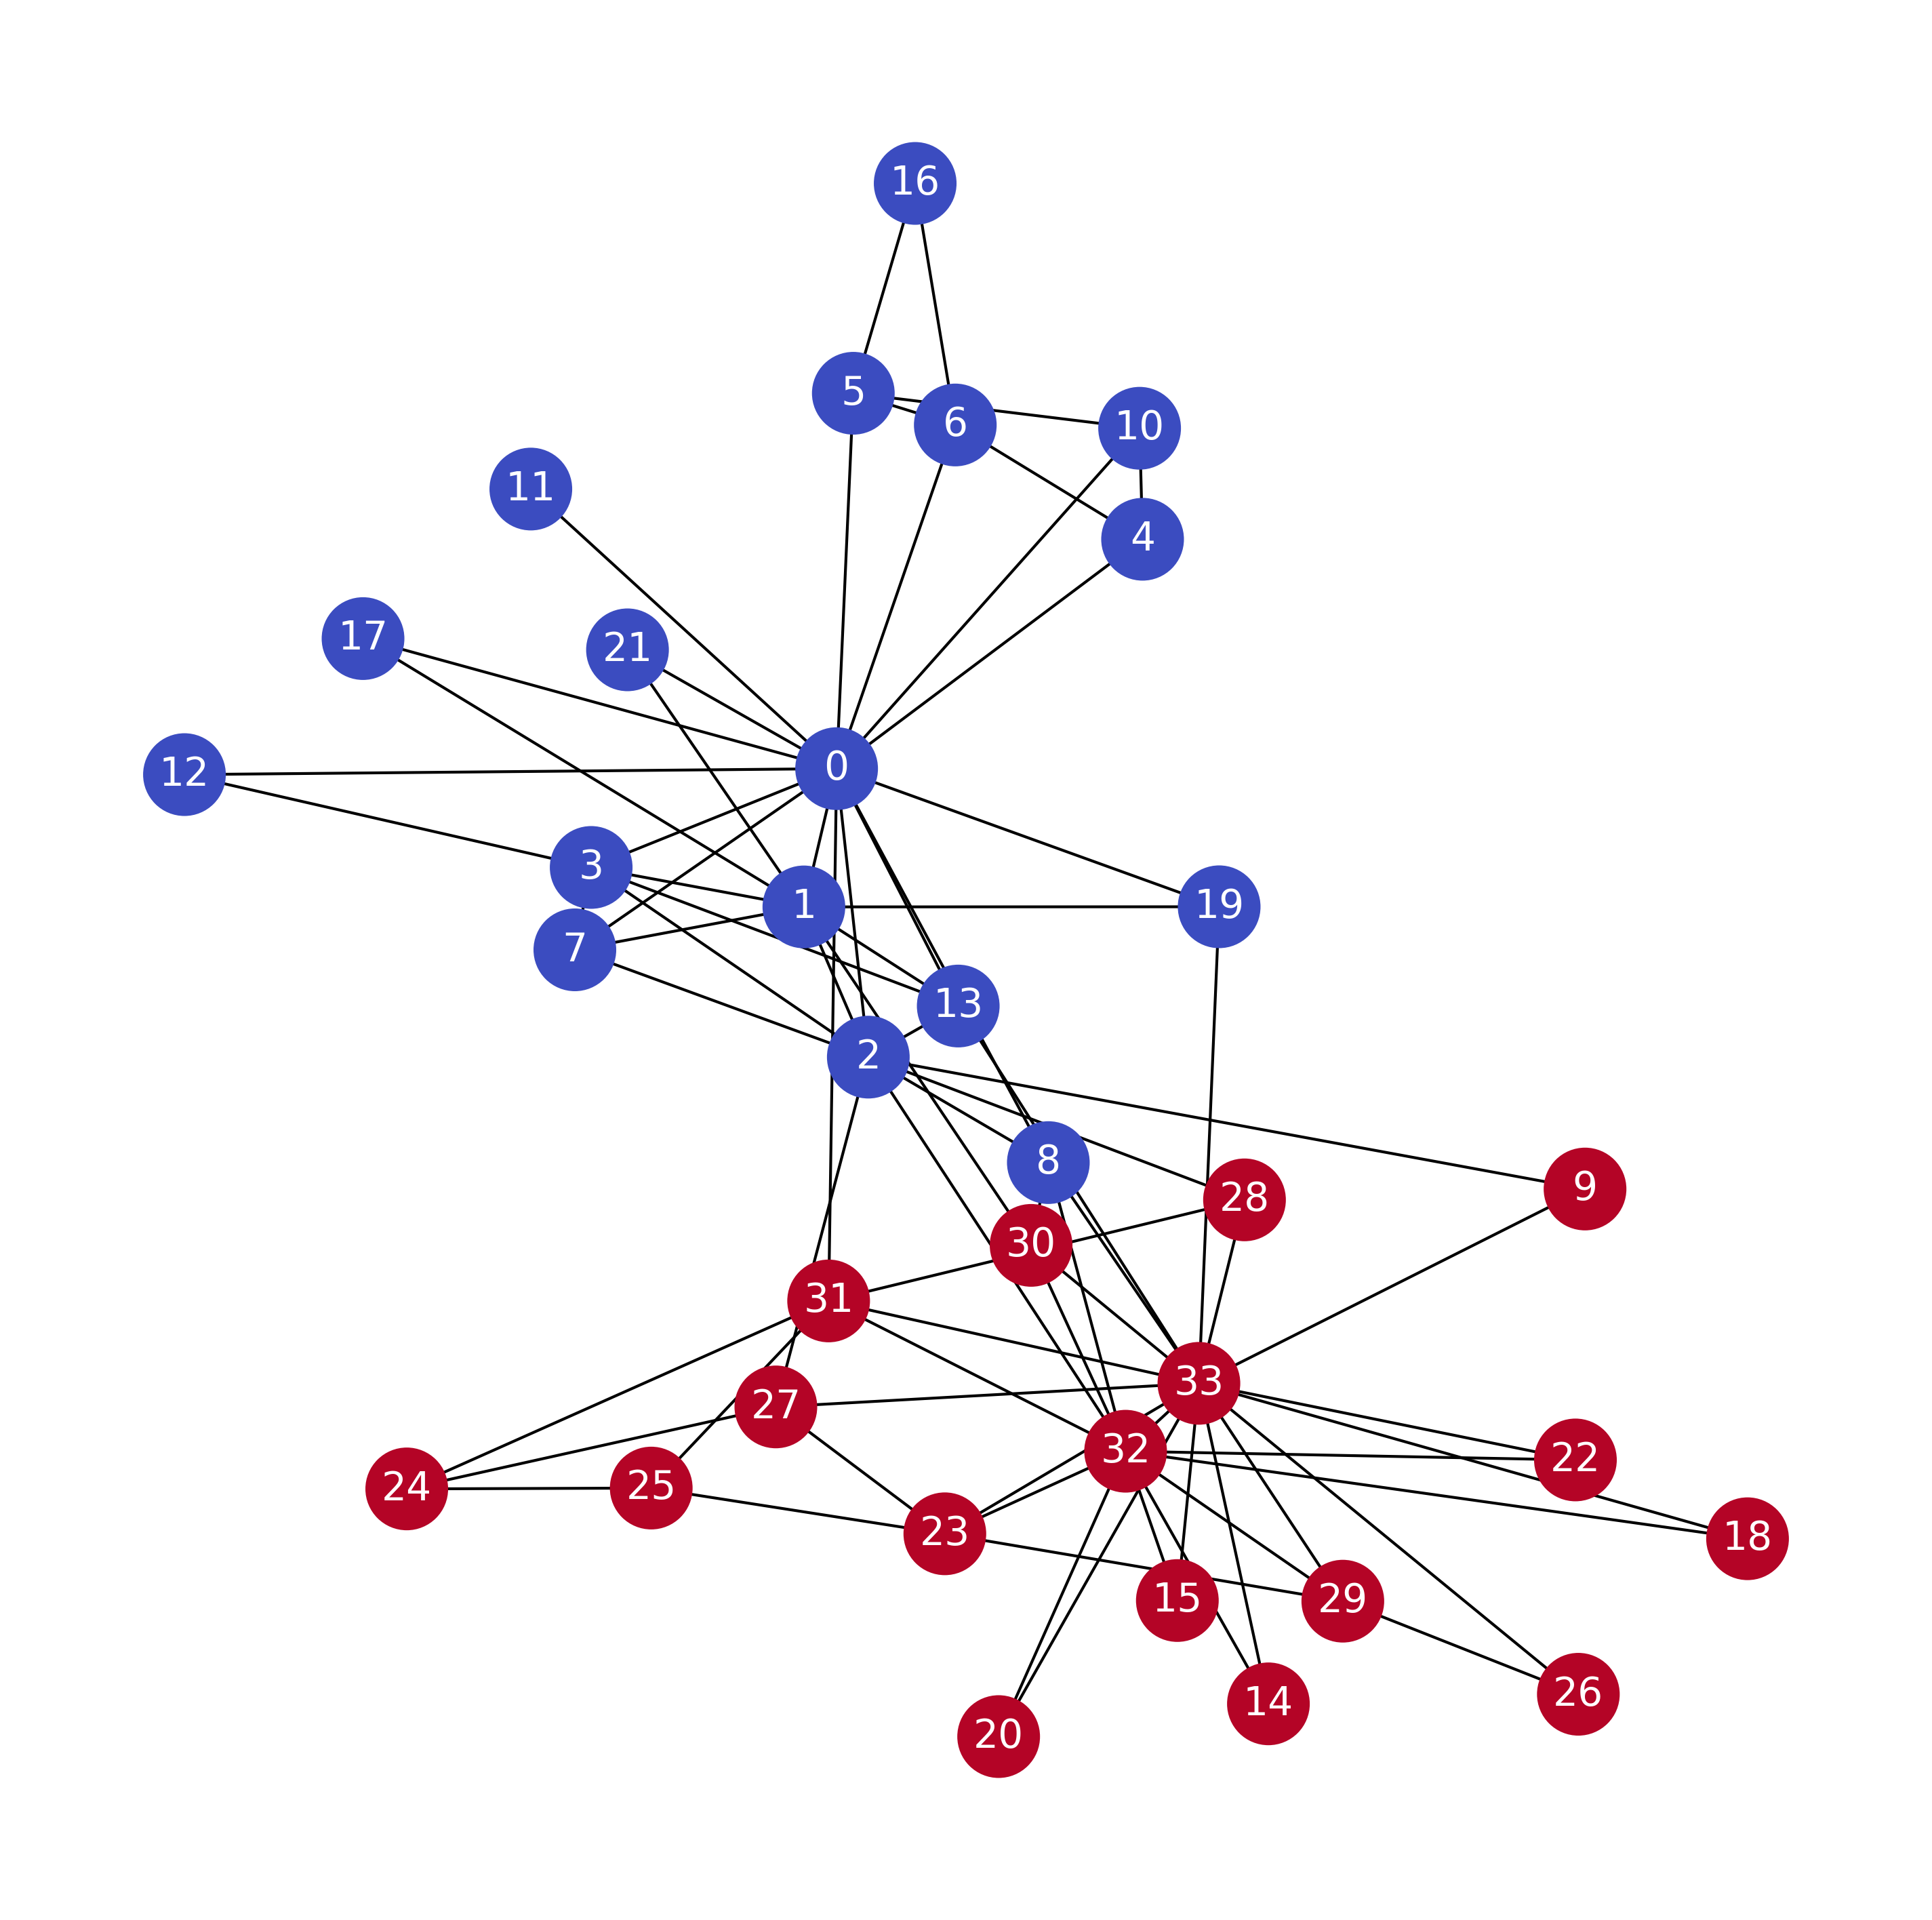

In [ ]:
plt.figure(figsize=(12, 12), dpi=300)
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_color=labels,
                 node_size=800,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

The next step and the most important is to generate dataset of random walks. We want to be as exhaustive as possible, to get familiar with nodes neighbourhood as good as possible, which is why we will create 80 random walks of a length of 10 for every node in the graph.

In [ ]:
from collections import defaultdict

walks = []
for node in G.nodes():
    for _ in range(80):
        walks.append(random_walk(node, 10))

visit_counts = defaultdict(int)

for walk in walks:
    for node in walk:
        visit_counts[node] += 1

sorted_visit_counts = sorted(visit_counts.items(), key=lambda x: x[1], reverse=True)

print("Most visited nodes:")
for node, count in sorted_visit_counts[:10]:  # Display top 10 most visited nodes
    print(f"Node {node}: visited {count} times")


Most visited nodes:
Node 33: visited 3143 times
Node 0: visited 3026 times
Node 32: visited 2134 times
Node 2: visited 1784 times
Node 1: visited 1660 times
Node 3: visited 1137 times
Node 31: visited 1099 times
Node 23: visited 942 times
Node 13: visited 899 times
Node 8: visited 897 times


The final step consists of implementing Word2Vec. We will use the famous NLP skip-gram model with H-Softmax. You can play with the other parameters to improve the quality of the embeddings.

In [ ]:
from gensim.models import Word2Vec


model = Word2Vec(walks,
                 hs=1,
                 sg=1,
                 vector_size=128,
                 window=5,
                 negative=0,
                 min_count=2,
                 alpha=0.03,
                 min_alpha=0.0007,
                 workers=4,
                 seed=42)


model.train(walks, total_examples=model.corpus_count, epochs=50, report_delay=1)

model.save("graph_embeddings.model")



The model is then simply trained on the random walks we generated.

In [ ]:
model.train(walks, total_examples=model.corpus_count, epochs=30, report_delay=1) # training model using random walks

(187334, 897600)

Now that our model is trained, let’s see its different applications.

The first one allows us to find the most similar nodes to a given one (in terms of cosine similarity). Another important application is calculating the similarity score between two nodes.

In [ ]:
print('Nodes that are the most similar to node 0:')
for similarity in model.wv.most_similar(positive=['0']):
    print(f'   {similarity}')

# Similarity between two nodes
print(f"\nSimilarity between node 0 and 4: {model.wv.similarity('0', '4')}")

Nodes that are the most similar to node 0:
   ('4', 0.6194189190864563)
   ('10', 0.5660184025764465)
   ('17', 0.5475279688835144)
   ('1', 0.5412474870681763)
   ('11', 0.5411879420280457)
   ('13', 0.5381151437759399)
   ('6', 0.5380856394767761)
   ('3', 0.5192471742630005)
   ('7', 0.5125218629837036)
   ('21', 0.5094826221466064)

Similarity between node 0 and 4: 0.6194189786911011


In [ ]:
# TODO 2: what are the two nodes that are the most similar to each other ?

most_similar_p = None
highest_similarity = -1


for node in G.nodes():

    similar_nodes = model.wv.most_similar(positive=[str(node)], topn=2)
    for similar_node, similarity in similar_nodes:

        if similarity > highest_similarity:
            highest_similarity = similarity
            most_similar_p = (node, similar_node)


print(f" most similar nodes: {most_similar_p}")
print(f"Similarity score: {highest_similarity}")


 most similar nodes: (18, '20')
Similarity score: 0.9016688466072083


# Let's try to plot the resulting embeddings. Yet we need to use t-distributed stochastic neighbor embedding (t-SNE) to visualize these high-dimensional vectors in 2D.

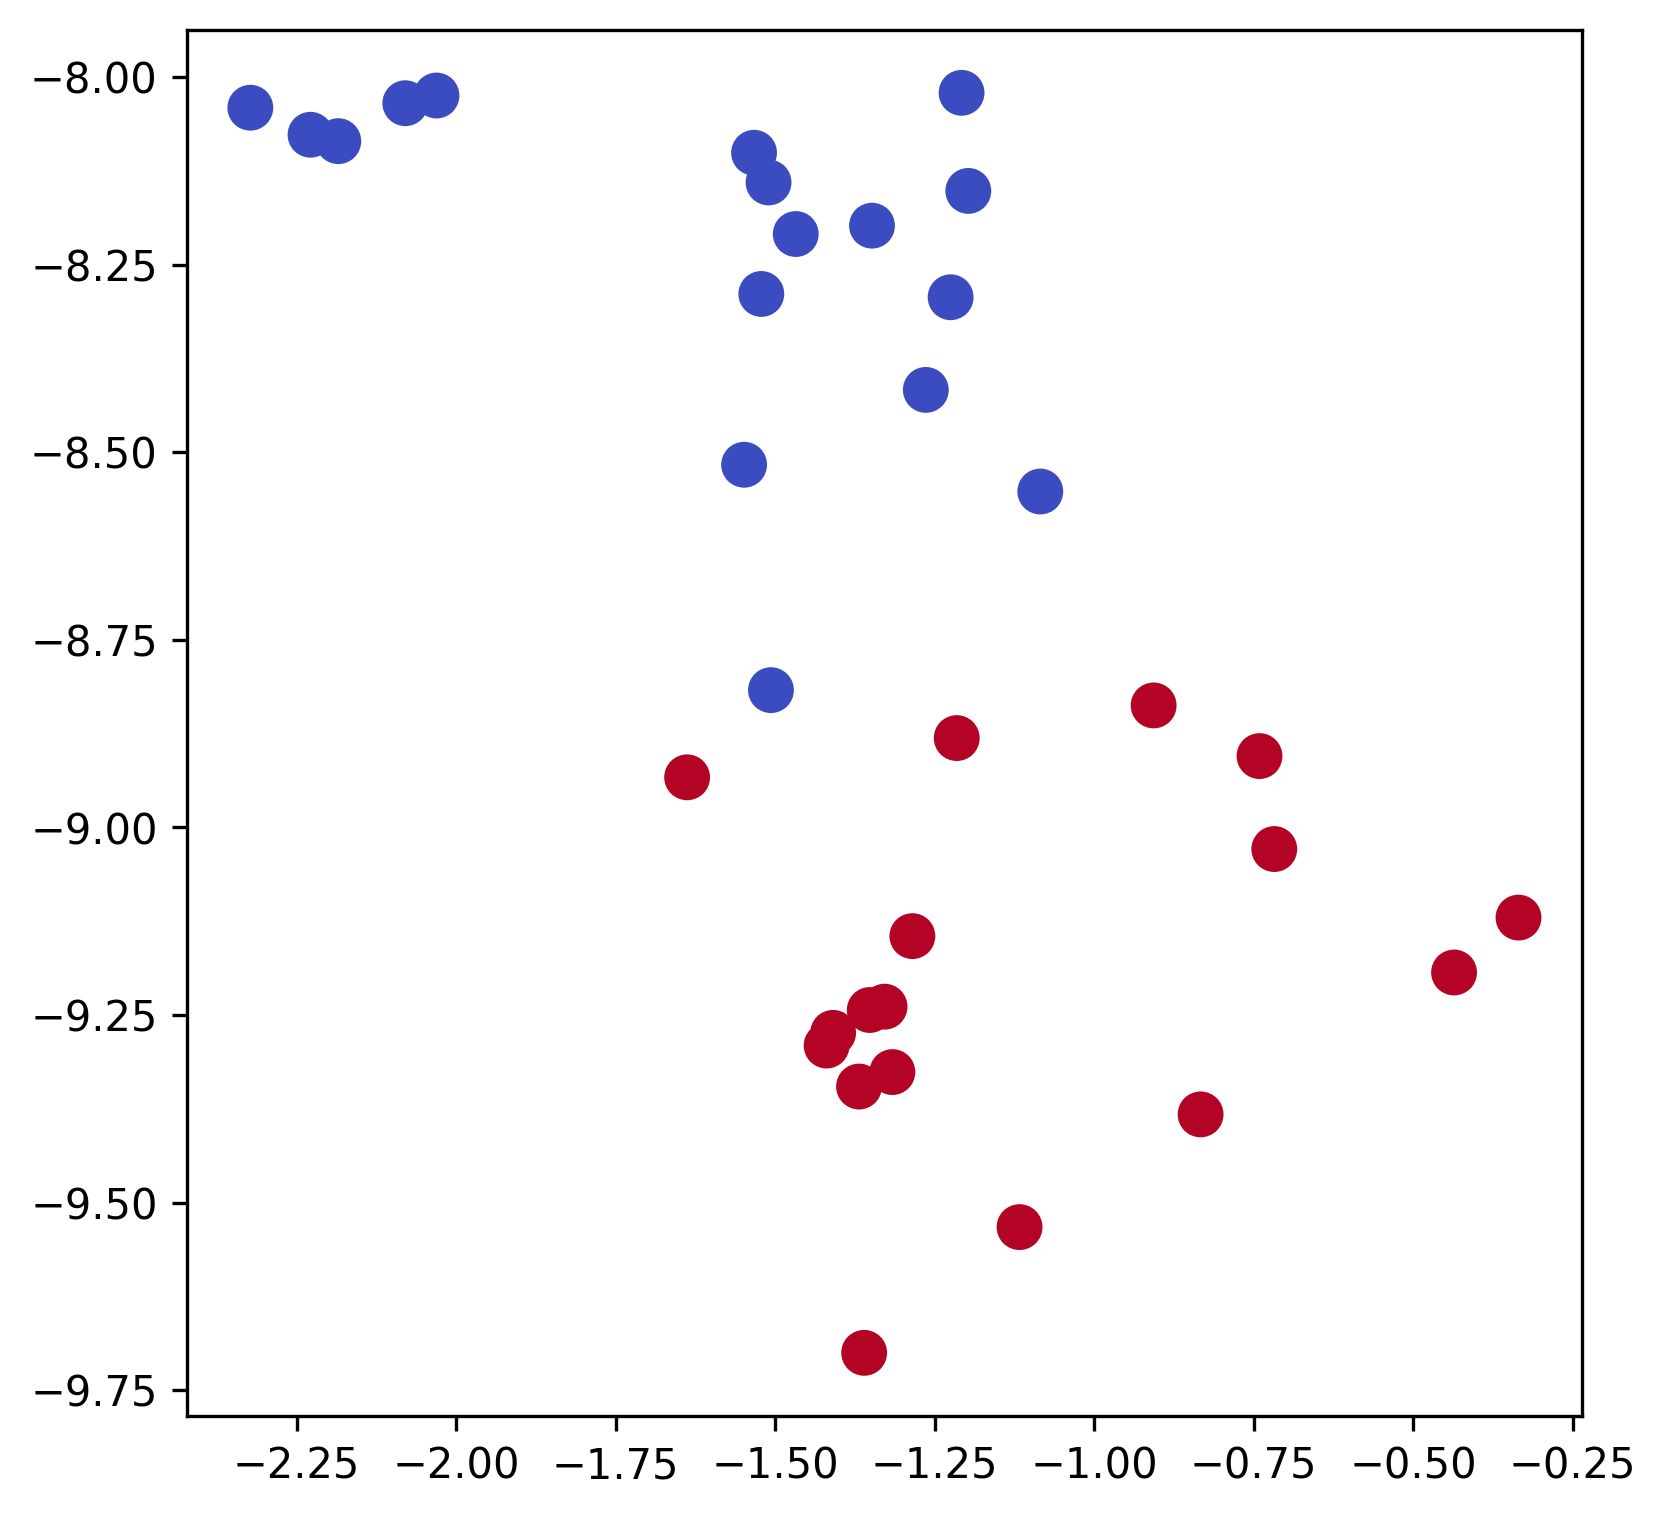

In [ ]:
from sklearn.manifold import TSNE

nodes_wv = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])
labels = np.array(labels)

tsne = TSNE(n_components=2, # two dimensions
            learning_rate='auto',
            init='pca',
            random_state=0).fit_transform(nodes_wv)

# plotting the reduced vectors produced by the model
plt.figure(figsize=(6, 6), dpi=300)
plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels, cmap="coolwarm")
plt.show()

This plot is quite encouraging since we can see a clear line that separates the two classes. It should be possible for a simple ML algorithm to classify these nodes with enough examples (training data). Let’s implement a classifier and train it on our node embeddings.

A Random Forest model from sklearn, is a popular choice when it comes to classification. The accuracy score is the metric we’ll use to evaluate this model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# split embedding into two groups - manually - let we will focus how to do it automatically
train_mask = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
test_mask = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 30, 31, 32, 33]

clf = RandomForestClassifier(random_state=0)  # let's create a model
clf.fit(nodes_wv[train_mask], labels[train_mask]) # let's train it on data of train_mask

y_pred = clf.predict(nodes_wv[test_mask])  # let's obtain predictions on data of test_mask
# let's check accuracy on test data prediction
print(f'DeepWalk accuracy = {accuracy_score(y_pred, labels[test_mask]) * 100:.2f}%')

DeepWalk accuracy = 89.47%


## Part 2: Attacking the graph

## Attacking the labels

In [ ]:
## TODO 3:
### Modify the variable "label" (defined in ### CELL LABELS ###) with random values. See the impact on t-distributed stochastic neighbor embedding (t-SNE) visualiation and the performance of the model

### CELL LABELS ###

labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

In [ ]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

num_iterations = 10
results = []

nodes_wv = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])

for _ in range(num_iterations):
    random_labels = [random.choice([0, 1]) for _ in G.nodes]

    train_mask_random = [i for i in range(len(random_labels)) if i % 2 == 0]
    test_mask_random = [i for i in range(len(random_labels)) if i % 2 != 0]

    clf_random = RandomForestClassifier(random_state=0)
    clf_random.fit(nodes_wv[train_mask_random], np.array(random_labels)[train_mask_random])

    y_pred_random = clf_random.predict(nodes_wv[test_mask_random])
    accuracy_random = accuracy_score(np.array(random_labels)[test_mask_random], y_pred_random)


    results.append((accuracy_random * 100, random_labels))


for i, (accuracy, labels) in enumerate(results):
    print(f"Iteration {i + 1}: Accuracy = {accuracy:.2f}%, Labels = {labels}")


Iteration 1: Accuracy = 47.06%, Labels = [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Iteration 2: Accuracy = 41.18%, Labels = [1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0]
Iteration 3: Accuracy = 52.94%, Labels = [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]
Iteration 4: Accuracy = 70.59%, Labels = [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0]
Iteration 5: Accuracy = 47.06%, Labels = [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]
Iteration 6: Accuracy = 47.06%, Labels = [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0]
Iteration 7: Accuracy = 41.18%, Labels = [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0

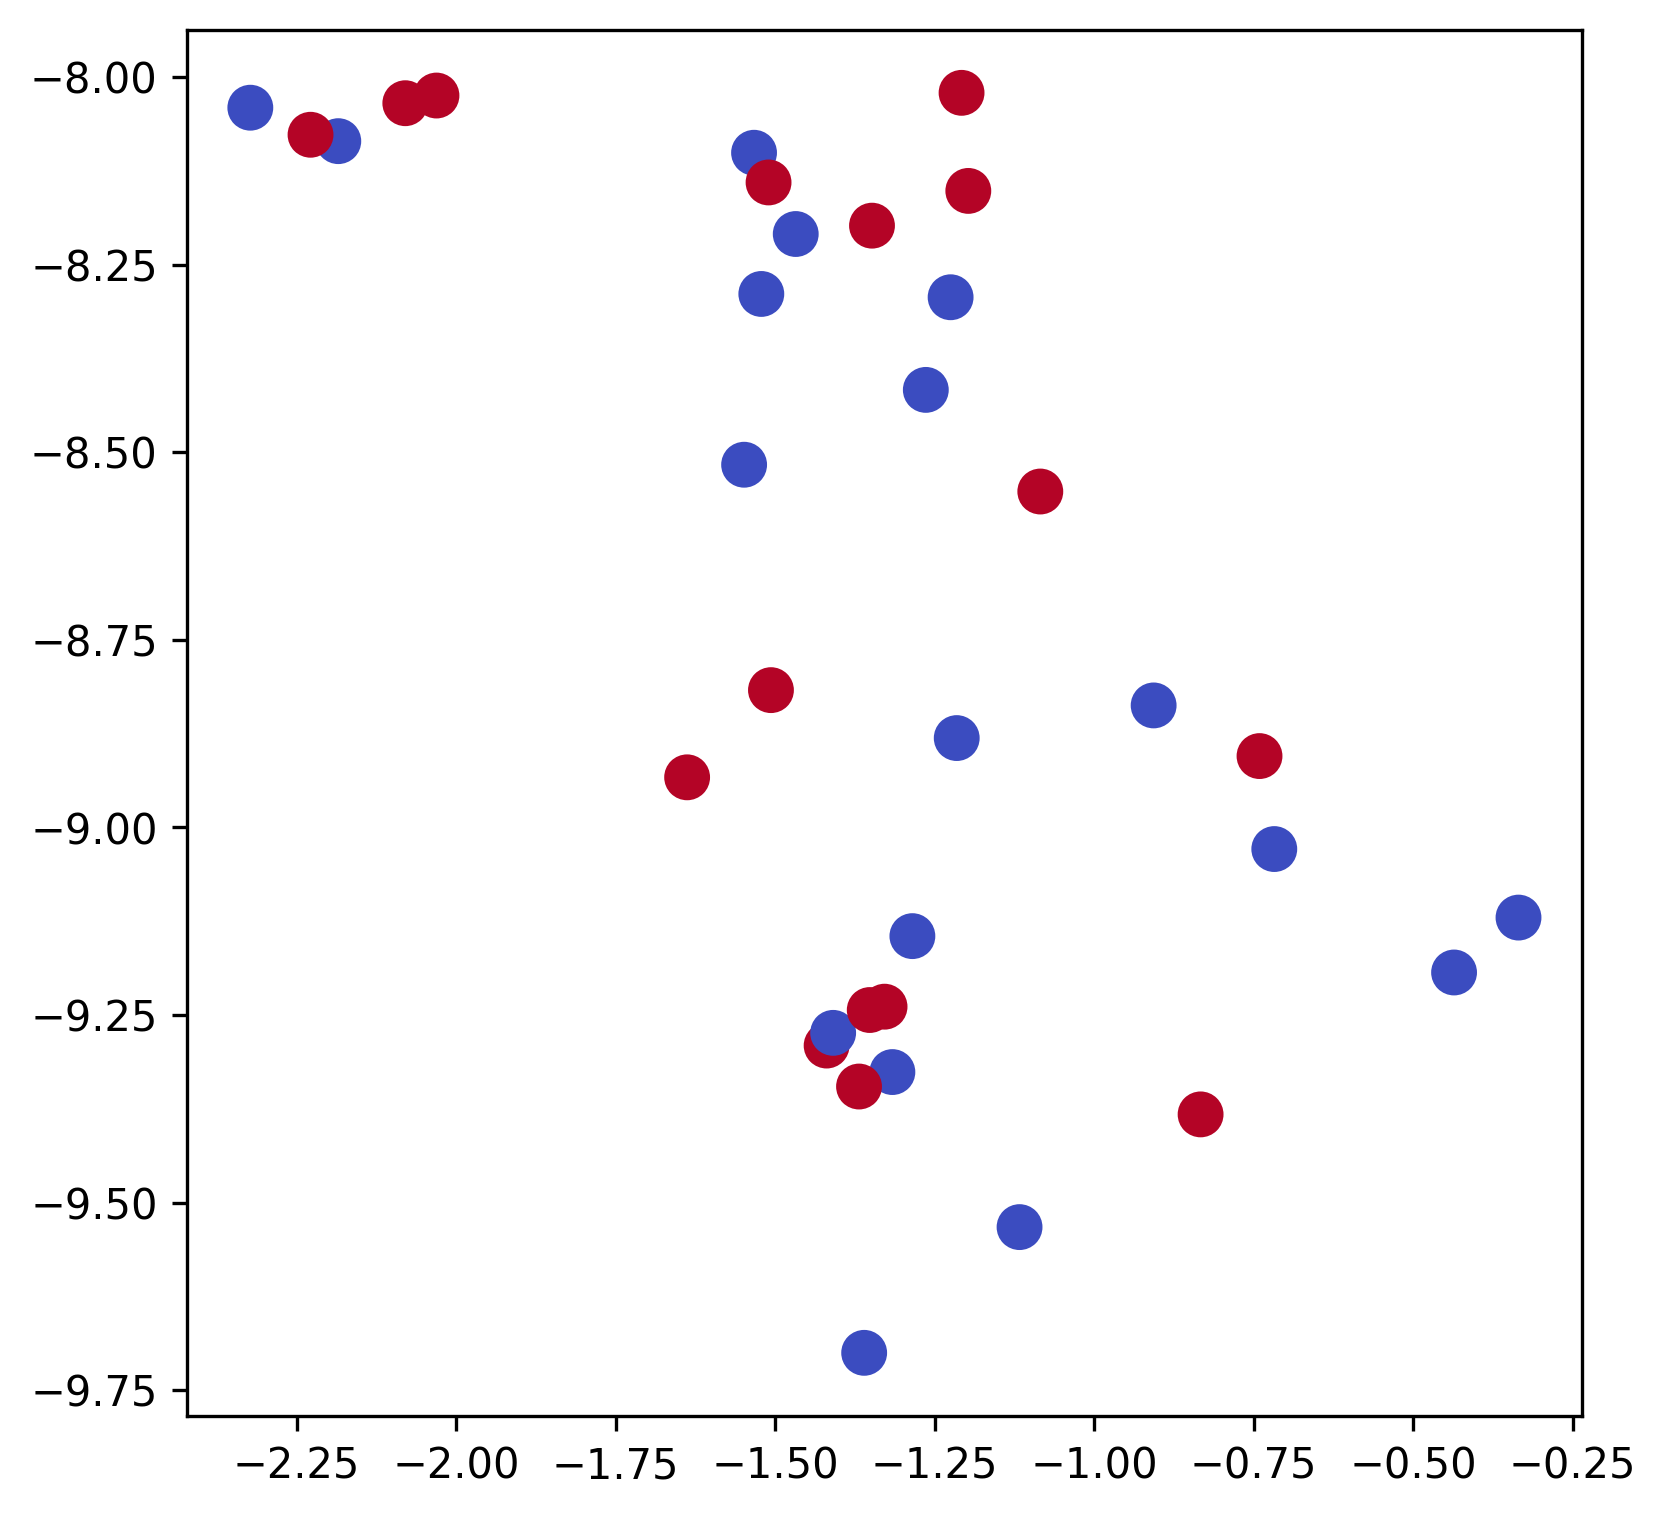

In [ ]:
# plotting the reduced vectors produced by the model
plt.figure(figsize=(6, 6), dpi=300)
plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels, cmap="coolwarm")
plt.show()

In [ ]:
## TODO 4:
### Evaluate corrupting the "label" variable progessively by flipping the true labels for N random nodes (N progressively increasing). Keep the evaluation on the original labels.
### Plot the accuracy of the Deep Walk model when N increases
### Repeat this experiment 5 times. Do you get the same plot?



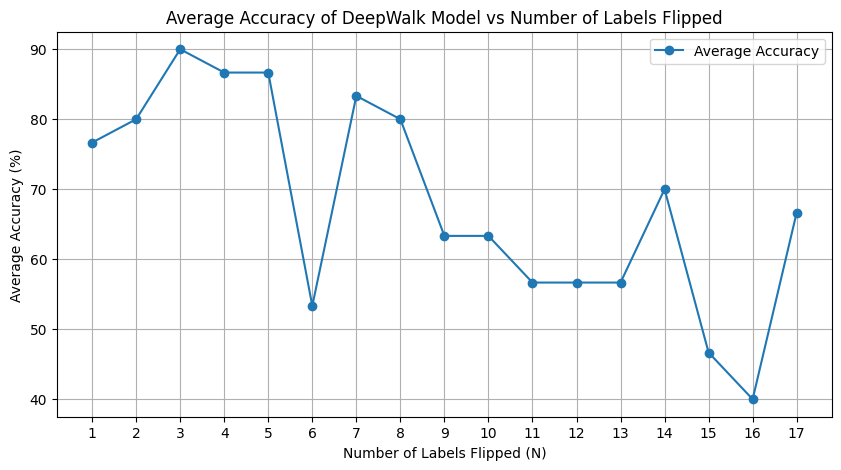

In [ ]:
import random
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


nodes_wv = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])


original_labels = np.array([1 if G.nodes[node]['club'] == 'Officer' else 0 for node in G.nodes])

train_mask = np.array([True if node < len(G.nodes) * 0.8 else False for node in range(len(G.nodes))])
test_mask = ~train_mask


def flip_labels(labels, N):
    flipped_labels = labels.copy()
    nodes_to_flip = random.sample(range(len(labels)), N)
    for node in nodes_to_flip:
        flipped_labels[node] = 1 - flipped_labels[node]
    return flipped_labels


num_repeats = 5
max_flips = len(G.nodes) // 2  # Maximum number of nodes to flip (adjust as needed)
average_accuracies = []


for N in range(1, max_flips + 1):
    accuracies = []

    for _ in range(num_repeats):

        flipped_labels = flip_labels(original_labels, N)


        clf = RandomForestClassifier()
        clf.fit(nodes_wv[train_mask], flipped_labels[train_mask])

        y_pred = clf.predict(nodes_wv[test_mask])
        accuracy = accuracy_score(original_labels[test_mask], y_pred)
        accuracies.append(accuracy * 100)


    average_accuracies.append(np.mean(accuracies))


iterations = list(range(1, max_flips + 1))

plt.figure(figsize=(10, 5))
plt.plot(iterations, average_accuracies, marker='o', label='Average Accuracy')
plt.title('Average Accuracy of DeepWalk Model vs Number of Labels Flipped')
plt.xlabel('Number of Labels Flipped (N)')
plt.ylabel('Average Accuracy (%)')
plt.xticks(iterations)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
## TODO 5:
### Can you find giving N increasing from 1 to 10 which N node causes the most decrease of accuracy of the model when they are flipped? Keep the evaluation on the original labels.
### Plot the accuracy of the RandomForestClassifier with increased N values.

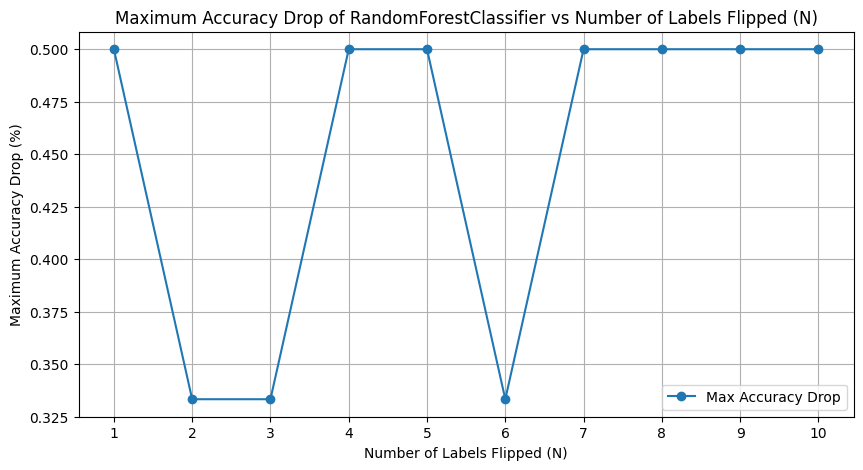

In [ ]:
import random
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Assuming you have a trained DeepWalk model (model.wv) and a graph G
# Prepare the node embeddings
nodes_wv = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])

# Original labels based on 'Officer' and 'Member'
original_labels = np.array([1 if G.nodes[node]['club'] == 'Officer' else 0 for node in G.nodes])

# Define train/test split masks
train_mask = np.array([True if node < len(G.nodes) * 0.8 else False for node in range(len(G.nodes))])
test_mask = ~train_mask

# Function to flip a specific label
def flip_label(labels, node):
    flipped_labels = labels.copy()
    flipped_labels[node] = 1 - flipped_labels[node]  # Flip 1 to 0, and 0 to 1
    return flipped_labels

# Store accuracies for each N
decrease_accuracies = []

# Loop over the number of labels to flip (N from 1 to 10)
for N in range(1, 11):
    accuracy_drops = []

    # Evaluate the accuracy drop for each of the nodes
    for node_to_flip in range(len(original_labels)):
        # Flip the label of the specific node
        flipped_labels = flip_label(original_labels, node_to_flip)

        # Train the classifier using the DeepWalk embeddings and flipped labels
        clf = RandomForestClassifier()
        clf.fit(nodes_wv[train_mask], flipped_labels[train_mask])

        # Predict using the classifier, but evaluate on the original labels
        y_pred = clf.predict(nodes_wv[test_mask])
        accuracy = accuracy_score(original_labels[test_mask], y_pred)

        # Calculate the drop in accuracy from the original accuracy
        original_accuracy = accuracy_score(original_labels[test_mask], original_labels[test_mask])
        accuracy_drop = original_accuracy - accuracy
        accuracy_drops.append(accuracy_drop)

    # Store the maximum accuracy drop for the current N
    decrease_accuracies.append(max(accuracy_drops))

# Plot the accuracy drops as N increases
iterations = list(range(1, 11))  # Number of labels flipped (N)

plt.figure(figsize=(10, 5))
plt.plot(iterations, decrease_accuracies, marker='o', label='Max Accuracy Drop')
plt.title('Maximum Accuracy Drop of RandomForestClassifier vs Number of Labels Flipped (N)')
plt.xlabel('Number of Labels Flipped (N)')
plt.ylabel('Maximum Accuracy Drop (%)')
plt.xticks(iterations)
plt.grid(True)
plt.legend()
plt.show()


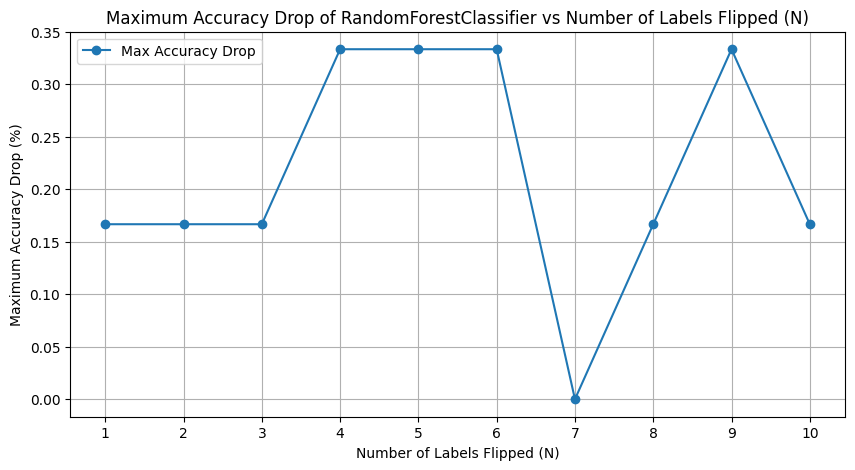

In [ ]:
# Repeat the experiment to get robust results
num_repeats = 5
max_flips = 10
decrease_accuracies = []

# Calculate the original accuracy using the original labels
clf = RandomForestClassifier()
clf.fit(nodes_wv[train_mask], original_labels[train_mask])
original_accuracy = accuracy_score(original_labels[test_mask], clf.predict(nodes_wv[test_mask]))

# Loop over the number of labels to flip
for N in range(1, max_flips + 1):
    accuracy_drops = []

    for _ in range(num_repeats):
        # Flip N random labels
        flipped_labels = flip_labels(original_labels, N)

        # Train the classifier using the flipped labels
        clf = RandomForestClassifier()
        clf.fit(nodes_wv[train_mask], flipped_labels[train_mask])

        # Predict using the classifier, but evaluate on the original labels
        y_pred = clf.predict(nodes_wv[test_mask])
        accuracy = accuracy_score(original_labels[test_mask], y_pred)

        # Calculate the drop in accuracy from the original accuracy
        accuracy_drop = original_accuracy - accuracy
        accuracy_drops.append(accuracy_drop)

    # Store the maximum average accuracy drop for this value of N
    decrease_accuracies.append(np.max(accuracy_drops))

# Plot the accuracy drops as N increases
iterations = list(range(1, max_flips + 1))

plt.figure(figsize=(10, 5))
plt.plot(iterations, decrease_accuracies, marker='o', label='Max Accuracy Drop')
plt.title('Maximum Accuracy Drop of RandomForestClassifier vs Number of Labels Flipped (N)')
plt.xlabel('Number of Labels Flipped (N)')
plt.ylabel('Maximum Accuracy Drop (%)')
plt.xticks(iterations)
plt.grid(True)
plt.legend()
plt.show()


## Bonus